In [1]:
%pip install nilearn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#Sample data

atlas = 'D:/Physiology_of_Action_Lab/Prisma_ITI_DePino/Schaefer2018_100Parcels_7Networks_order_Tian_Subcortex_S2_MNI152NLin6Asym_2mm.nii.gz'
events_file = 'D:/Physiology_of_Action_Lab/Prisma_ITI_DePino/sub-01/func/sub-01_task-mslWithITI_dir-AP_events.tsv'
bold_file = 'D:/Physiology_of_Action_Lab/Prisma_ITI_DePino/derivatives/sub-01/sub-01_task-mslWithITI_dir-AP_desc-smooth_space-IXI549Space_bold.nii.gz'

In [ ]:
import pandas as pd

def load_events(events_file):
    return pd.read_table(events_file, sep='\t')


def add_baseline(events_df):
    new_df = events_df.copy()
    new_df.loc[-1] = [0.0, new_df['onset'].min() , 'baseline', 0]
    new_df.index = new_df.index + 1
    new_df.sort_index(inplace=True) 
    return new_df

def add_amplitude(events_df):
    new_df = events_df.copy()
    new_df['amplitude'] = 1.0
    return new_df

def onsets_to_tr(events_df, tr):
    new_df = events_df.copy()
    new_df['tr_start'] = (new_df['onset'] / tr).round().astype(int)
    
    tr_durations = new_df['tr_start'].shift(-1, fill_value=-1) -  new_df['tr_start'] - 1
    tr_durations.iloc[-1] = (new_df['duration'].iloc[-1] / tr).astype(int) - 1
    new_df['tr_duration'] = tr_durations

    new_df['tr_end'] = new_df['tr_start'] + new_df['tr_duration']
    return new_df

def classify_stage(events_df, n_early_blocks, n_late_blocks, column='block_n'):
    new_df = events_df.copy()
    stage = []
    for index, row in new_df.iterrows():
        block = row[column]
        if block > 0 and block <= n_early_blocks:
            stage.append('early')
        elif block > 0 and block >= (new_df[column].max()-n_late_blocks+1):
            stage.append('late')
        else:
            stage.append(pd.NA)
    new_df['stage'] = stage
    return new_df

def get_blocks(events_df, condition=None, stage=None):
    if condition is not None:
        if stage is not None:
            return events_df[(events_df['trial_type'] == condition) & (events_df['stage'] == stage)]
        else:
            return events_df[events_df['trial_type'] == condition]
    if stage is not None:
        return events_df[events_df['stage'] == stage]
    return events_df

def onsets_to_design(events_df, n_volumes, start_column='tr_start', end_column='tr_end', amplitude_column='amplitude'):
    import numpy as np
    design = np.zeros(n_volumes)
    for index, row in events_df.iterrows():
        start = row[start_column]
        end = row[end_column]
        amplitude = row[amplitude_column]
        design[start:end+1] = amplitude
    return design

def convolve(signal, tr):
    from nilearn.glm.first_level import spm_hrf
    import numpy as np
    return np.convolve(signal, spm_hrf(tr))

events = load_events(events_file)
events = add_baseline(events)
events = add_amplitude(events)
events = classify_stage(events, 2, 2)
events = onsets_to_tr(events, 0.5)
design = onsets_to_design(get_blocks(events, condition='task', stage='early'), events['tr_end'].max())

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

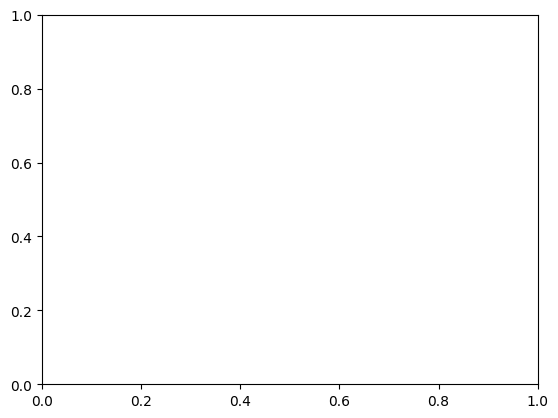

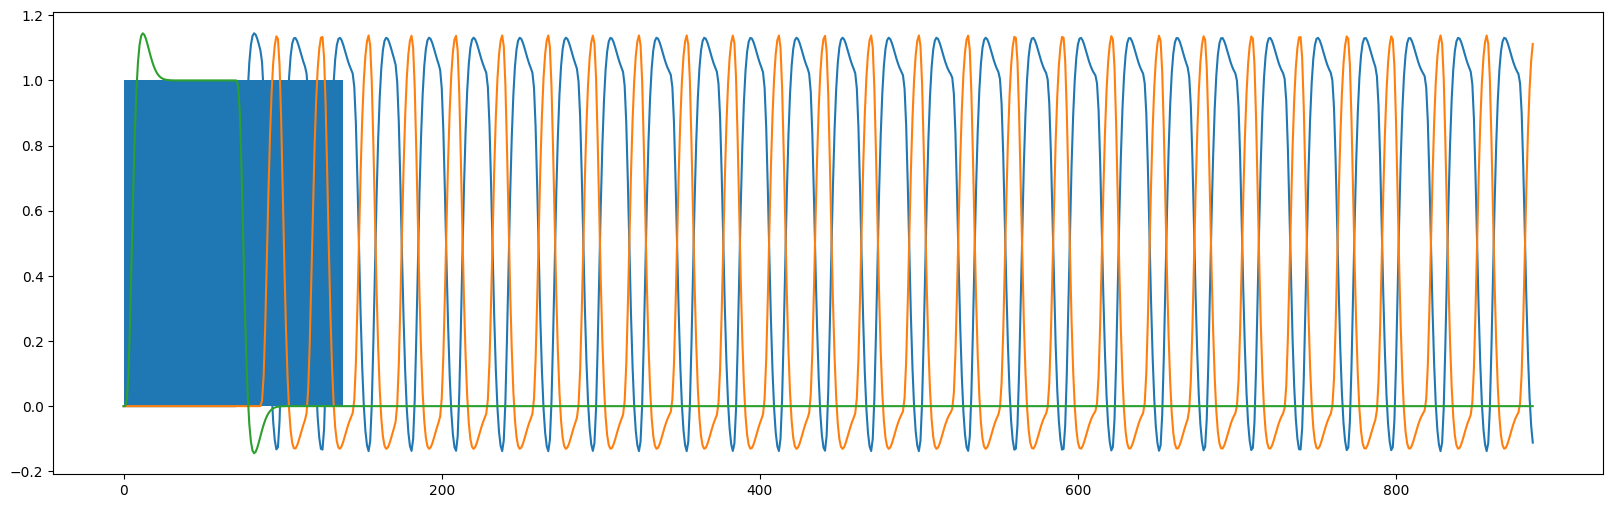

In [166]:
from nilearn.glm.first_level import compute_regressor
import numpy as np
import matplotlib.pyplot as plt

exp_condition = np.array(get_blocks(events, condition='task')[['onset', 'duration', 'amplitude']]).transpose()
frame_times = np.arange(0, (events['onset']+events['duration']).max()+1)

signal_task, labels = compute_regressor(
    exp_condition=np.array(get_blocks(events, condition='task')[['onset', 'duration', 'amplitude']]).transpose(),
    hrf_model='spm',
    frame_times=frame_times
)
signal_rest, labels = compute_regressor(
    exp_condition=np.array(get_blocks(events, condition='rest')[['onset', 'duration', 'amplitude']]).transpose(),
    hrf_model='spm',
    frame_times=frame_times
)
signal_baseline, labels = compute_regressor(
    exp_condition=np.array(get_blocks(events, condition='baseline')[['onset', 'duration', 'amplitude']]).transpose(),
    hrf_model='spm',
    frame_times=frame_times
)

plt.figure(figsize=(20, 6))
plt.plot(signal_task)
plt.plot(signal_rest)
plt.plot(signal_baseline)
len(signal_task)
plt.fill_between(np.arange(0,1771), 0, 1, where=design>0)



"design = onsets_to_design(get_blocks(events, condition='task'), events['tr_end'].max())\nconv = np.convolve(spm_hrf(0.5, oversampling=1), design)\nplt.plot(conv)\ndesign = onsets_to_design(get_blocks(events, condition='baseline'), events['tr_end'].max())\nconv = np.convolve(spm_hrf(0.5, oversampling=1), design)\nplt.plot(conv)"

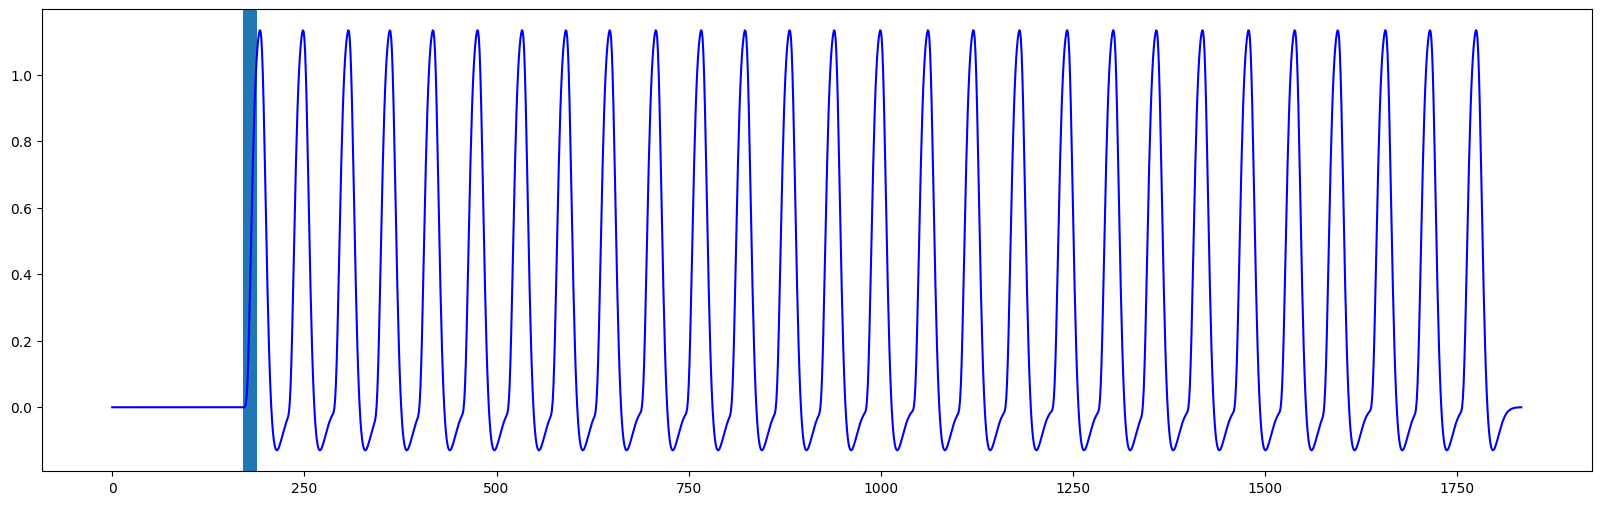

In [204]:
from nilearn.glm.first_level import spm_hrf

design = onsets_to_design(get_blocks(events, condition='rest'), events['tr_end'].max())
conv = np.convolve(spm_hrf(0.5, oversampling=1), design)
plt.figure(figsize=(20, 6))
plt.plot(conv, color='blue')
plt.axvspan(events['tr_start'].iloc[2], events['tr_end'].iloc[2])
'''design = onsets_to_design(get_blocks(events, condition='task'), events['tr_end'].max())
conv = np.convolve(spm_hrf(0.5, oversampling=1), design)
plt.plot(conv)
design = onsets_to_design(get_blocks(events, condition='baseline'), events['tr_end'].max())
conv = np.convolve(spm_hrf(0.5, oversampling=1), design)
plt.plot(conv)'''